## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [2]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[64, 32, 16]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for idx, n in enumerate(num_neurons):
        if idx == 0:
            x = keras.layers.Dense(units=n, activation="relu", name="hidden_layer%d" % (idx))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n, activation="relu", name="hidden_layer%d" % (idx))(x)
            x = BatchNormalization()(x)
    
    output_layer = keras.layers.Dense(units=output_units, activation="softmax", name="output_layer")(x)
    
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [21]:
# 載入 Callbacks
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix

# Record_fp_tp
class Record_tp_tn(Callback):
    """Code Here
    撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks    
    """
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        print(len(self.validation_data))
        for idx, a in enumerate(self.validation_data):
            if isinstance(a, float):
                print(idx, a)
            else:
                print(idx, a.shape)
        y_pred = self.model.predict(self.validation_data[0]).argmax(axis = 1)
        print(y_pred.shape, y_pred[:10])
        y_true = self.validation_data[1].argmax(axis = 1)
        print(y_true.shape, y_true[:10])
        
        cm = confusion_matrix(y_true, y_pred)
        print(cm)
        
        for i in range(10):
            logs['valid_tp_%d' % (i)] = cm[i][i] / sum(cm[i])
            logs['valid_tn_%d' % (i)] = (len(y_true) - sum(cm[i]) - sum(cm[:, i]) + cm[i][i]) / len(y_true)
        
rec_tptn = Record_tp_tn()

In [22]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""
# valid_tp = model.history.history["valid_tp"]
# valid_tn = model.history.history["valid_tn"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 64)                196672    
_________________________________________________________________
batch_normalization_22 (Batc (None, 64)                256       
_________________________________________________________________
hidden_layer1 (Dense)        (None, 32)                2080      
_________________________________________________________________
batch_normalization_23 (Batc (None, 32)                128       
_________________________________________________________________
hidden_layer2 (Dense)        (None, 16)                528       
_________________________________________________________________
batch_normalization_24 (Batc (None, 16)                64        
__________

50000/50000 [==============================] - 3s 53us/step - loss: 1.6158 - acc: 0.4307 - val_loss: 1.6515 - val_acc: 0.4119
4
0 (10000, 3072)
1 (10000, 10)
2 (10000,)
3 0.0
(10000,) [3 8 8 8 6 6 5 6 4 9]
(10000,) [3 8 8 0 6 6 1 6 3 1]
[[524  33  34  23  32  37  34  62 151  70]
 [ 43 433   7  52  18  41  58  31 101 216]
 [130  18 133  78 191 105 201  85  36  23]
 [ 35  22  37 198  71 296 188  51  38  64]
 [ 74   5  81  48 363  79 202 101  25  22]
 [ 30   9  37 151  82 410 142  64  50  25]
 [  6  13  54  87  97 110 541  41  11  40]
 [ 43  17  18  73 111 117  88 422  37  74]
 [135  77  14  52  16  39  15  16 545  91]
 [ 53 129   5  43  11  27  48  55  79 550]]
Epoch 12/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.6001 - acc: 0.4359 - val_loss: 1.6514 - val_acc: 0.4160
4
0 (10000, 3072)
1 (10000, 10)
2 (10000,)
3 0.0
(10000,) [3 9 8 8 6 6 5 4 4 1]
(10000,) [3 8 8 0 6 6 1 6 3 1]
[[453  49  34  25  48  32  38  76 166  79]
 [ 30 533   6  44  27  24  35  32  70 19

50000/50000 [==============================] - 3s 50us/step - loss: 1.4759 - acc: 0.4806 - val_loss: 1.5854 - val_acc: 0.4392
4
0 (10000, 3072)
1 (10000, 10)
2 (10000,)
3 0.0
(10000,) [3 8 8 8 4 6 5 6 2 1]
(10000,) [3 8 8 0 6 6 1 6 3 1]
[[472  47  97  24  20  23  32  35 209  41]
 [ 31 640  22  35  12  22  37  16  70 115]
 [ 96  38 324  76 156  79 130  43  44  14]
 [ 26  42 117 231  71 242 149  40  53  29]
 [ 55  16 219  52 360  50 135  71  28  14]
 [ 20  24  96 159  82 383 109  51  51  25]
 [  3  32 141  77 100  74 507  36  16  14]
 [ 40  36  81  56 112 100  56 434  35  50]
 [ 84 105  30  34  14  23  11  12 643  44]
 [ 46 267  11  40  16  23  45  55  99 398]]
Epoch 24/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.4672 - acc: 0.4843 - val_loss: 1.5786 - val_acc: 0.4375
4
0 (10000, 3072)
1 (10000, 10)
2 (10000,)
3 0.0
(10000,) [3 9 8 8 4 6 5 6 2 1]
(10000,) [3 8 8 0 6 6 1 6 3 1]
[[489  50  59  54  16  35  30  52 158  57]
 [ 29 588  11  67  10  26  40  24  59 14

'Code Here\n將 tp/tn 從訓練完的模型中取出\n'

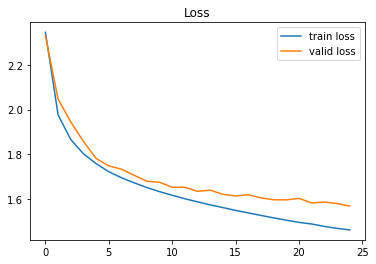

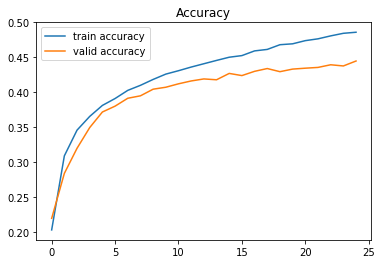

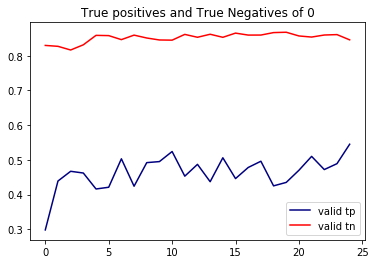

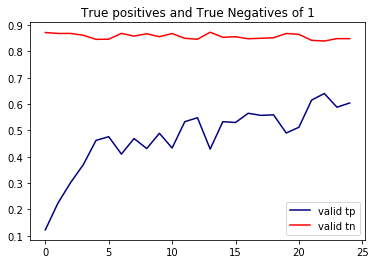

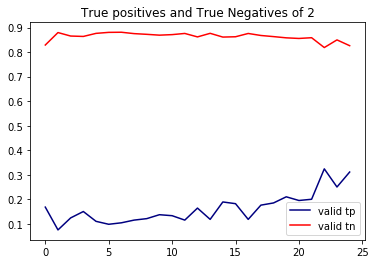

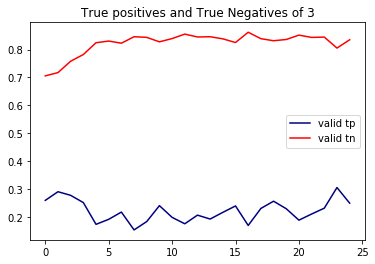

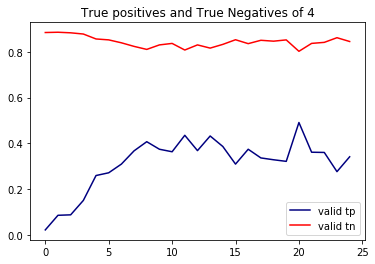

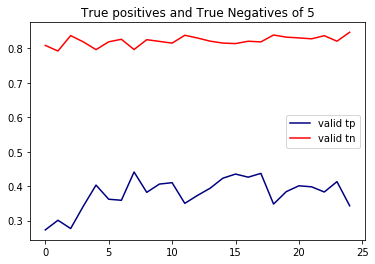

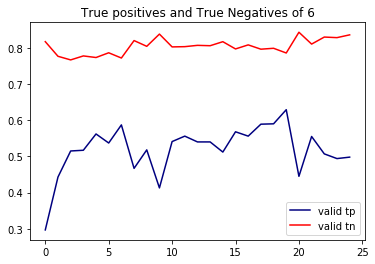

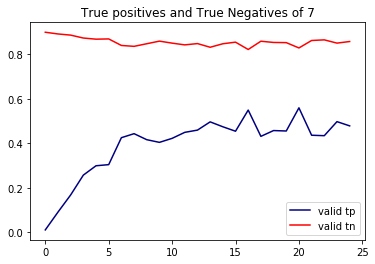

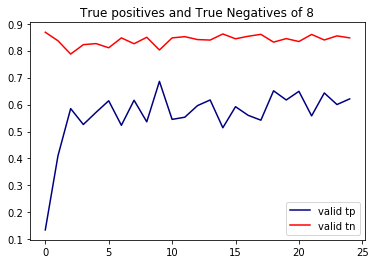

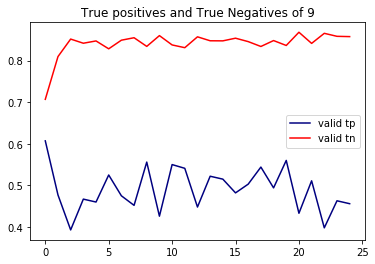

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

for i in range(10):
    plt.plot(range(len(model.history.history["valid_tp_%d" % (i)])), model.history.history["valid_tp_%d" % (i)], label="valid tp", color="navy")
    plt.plot(range(len(model.history.history["valid_tn_%d" % (i)])), model.history.history["valid_tn_%d" % (i)], label="valid tn", color="red")
    plt.legend()
    plt.title("True positives and True Negatives of %d" %(i))
    plt.show()
